1. Ищем статьи, в которых разобраны методы для раман спектров.
2. Посмотреть алгоритм декомпозиции на гауссианы. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import pickle


In [2]:
from utils import (
    train_template,
    get_metrics, 
    random_forest_train, 
    xgboost_train, 
    catboost_train
)

/home/lazarev/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:125: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [3]:
def fixed_data_loading(fg_file, ga_file):
    y = []
    X_raw = []
    for filename in (fg_file, ga_file):
        with open(filename, 'r') as f:
            for line in f.readlines():
                tmp_array = [float(i) for i in line.split(';')]
                y.append(tmp_array[0])
                X_raw.append(tmp_array[1:])
    y = np.array(y)
    for index, element in enumerate(set(y)):
        y[y == element] = index
        
    return X_raw, y

X_peaks, y = fixed_data_loading(
    "dataSrc/peaks-fg-105-sign_before-hydr.csv",
    "dataSrc/peaks-fg-105-sign_after-hydr.csv", 
)
print(len(X_peaks), len(y))

569 569


In [4]:
# y

In [5]:
# def data_loading(ga_file, fg_file, header=None):
#     data_ga = pd.read_csv(ga_file, sep=";", header=header)
#     data_fg = pd.read_csv(fg_file, sep=";", header=header)
#     columns = data_ga.columns.values
    
#     y_fg = data_fg[columns[0]].values
#     X_fg = data_fg.drop(columns=columns[0])

#     y_ga = data_ga[columns[0]].values
#     X_ga = data_ga.drop(columns=columns[0])
    
#     y = np.concatenate((y_fg, y_ga), axis=0)
#     X = np.concatenate((X_fg, X_ga), axis=0)
    
#     x_axis = columns[1:][: : -1].astype(float)
    
#     return X, y, x_axis

def data_loading(ga_file, fg_file, header=None):
    data_fg = pd.read_csv(fg_file, sep=";", header=header)
    columns = data_fg.columns.values
    
    y_fg = data_fg[columns[0]].values
    X_fg = data_fg.drop(columns=columns[0]).values
    
    for index, element in enumerate(set(y_fg)):
        y_fg[y_fg == element] = index
        
    x_axis = columns[1:][: : -1].astype(float)
    
    return X_fg, y_fg, x_axis

spectras, spectra_labels, x_axis = data_loading(
    "dataSrc/ga_2_3_5_6.csv", 
    "dataSrc/fg_1-5_7-11.csv",
    'infer'
)

In [6]:
with open('filename.pickle', 'wb') as f:
    pickle.dump(spectras[0], f, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as f:
    b = pickle.load(f)

print(spectras[0] == b)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [7]:
spectras.shape

(569, 994)

In [8]:
# spectra_labels == y

In [9]:
def find_min_peak_distance(X):
    min_distance = max(X[0])
    for j, spectra in enumerate(X):
        for index in range(len(spectra[:-1])):
#             spectra.sort()
            if spectra[index+1] - spectra[index] < min_distance:
#                 print(spectra[index+1] - spectra[index], spectra[index+1], spectra[index], j)
                min_distance = spectra[index+1] - spectra[index]
    return min_distance

min_distance = find_min_peak_distance(X_peaks)
min_distance

3.6908999999998287

In [10]:
def create_grid(x_axis, min_distance):
    result_grid = [x_axis[0]]
#     print(result_grid)
    for index, element in enumerate(x_axis):
        if result_grid[-1] + min_distance < element:
            result_grid.append(x_axis[index-1])
    return np.array(result_grid)

result_grid = create_grid(x_axis, min_distance)

In [11]:
def fill_the_grid(result_grid, X_peaks):
    filled_grid = np.zeros((len(X_peaks), result_grid.shape[0]-1))
#     print(filled_grid.shape)
    for index, peaks in enumerate(X_peaks):
        start_point = 0
        peak_num = 0
#         while start_point != result_grid[-1]:
        while peak_num < len(peaks):
#             print(peak_num, start_point, peaks[peak_num], result_grid[start_point])
            if peaks[peak_num] < result_grid[start_point]:
#                 filled_grid[index][start_point-1] = 1
                filled_grid[index][start_point-1] = peaks[peak_num]
                peak_num += 1
            start_point += 1
#     for i in range(filled_grid.shape[1] - 1, -1, -1):
# #         print(i)
#         if filled_grid[:, i].sum() == 0:
#             filled_grid = np.delete(filled_grid, i, 1)
    
    return filled_grid


# filled_grid = fill_the_grid(result_grid, X_peaks)
filled_grid = fill_the_grid(x_axis, X_peaks)

number of peaks: 96, number of spectra: 107


/home/lazarev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


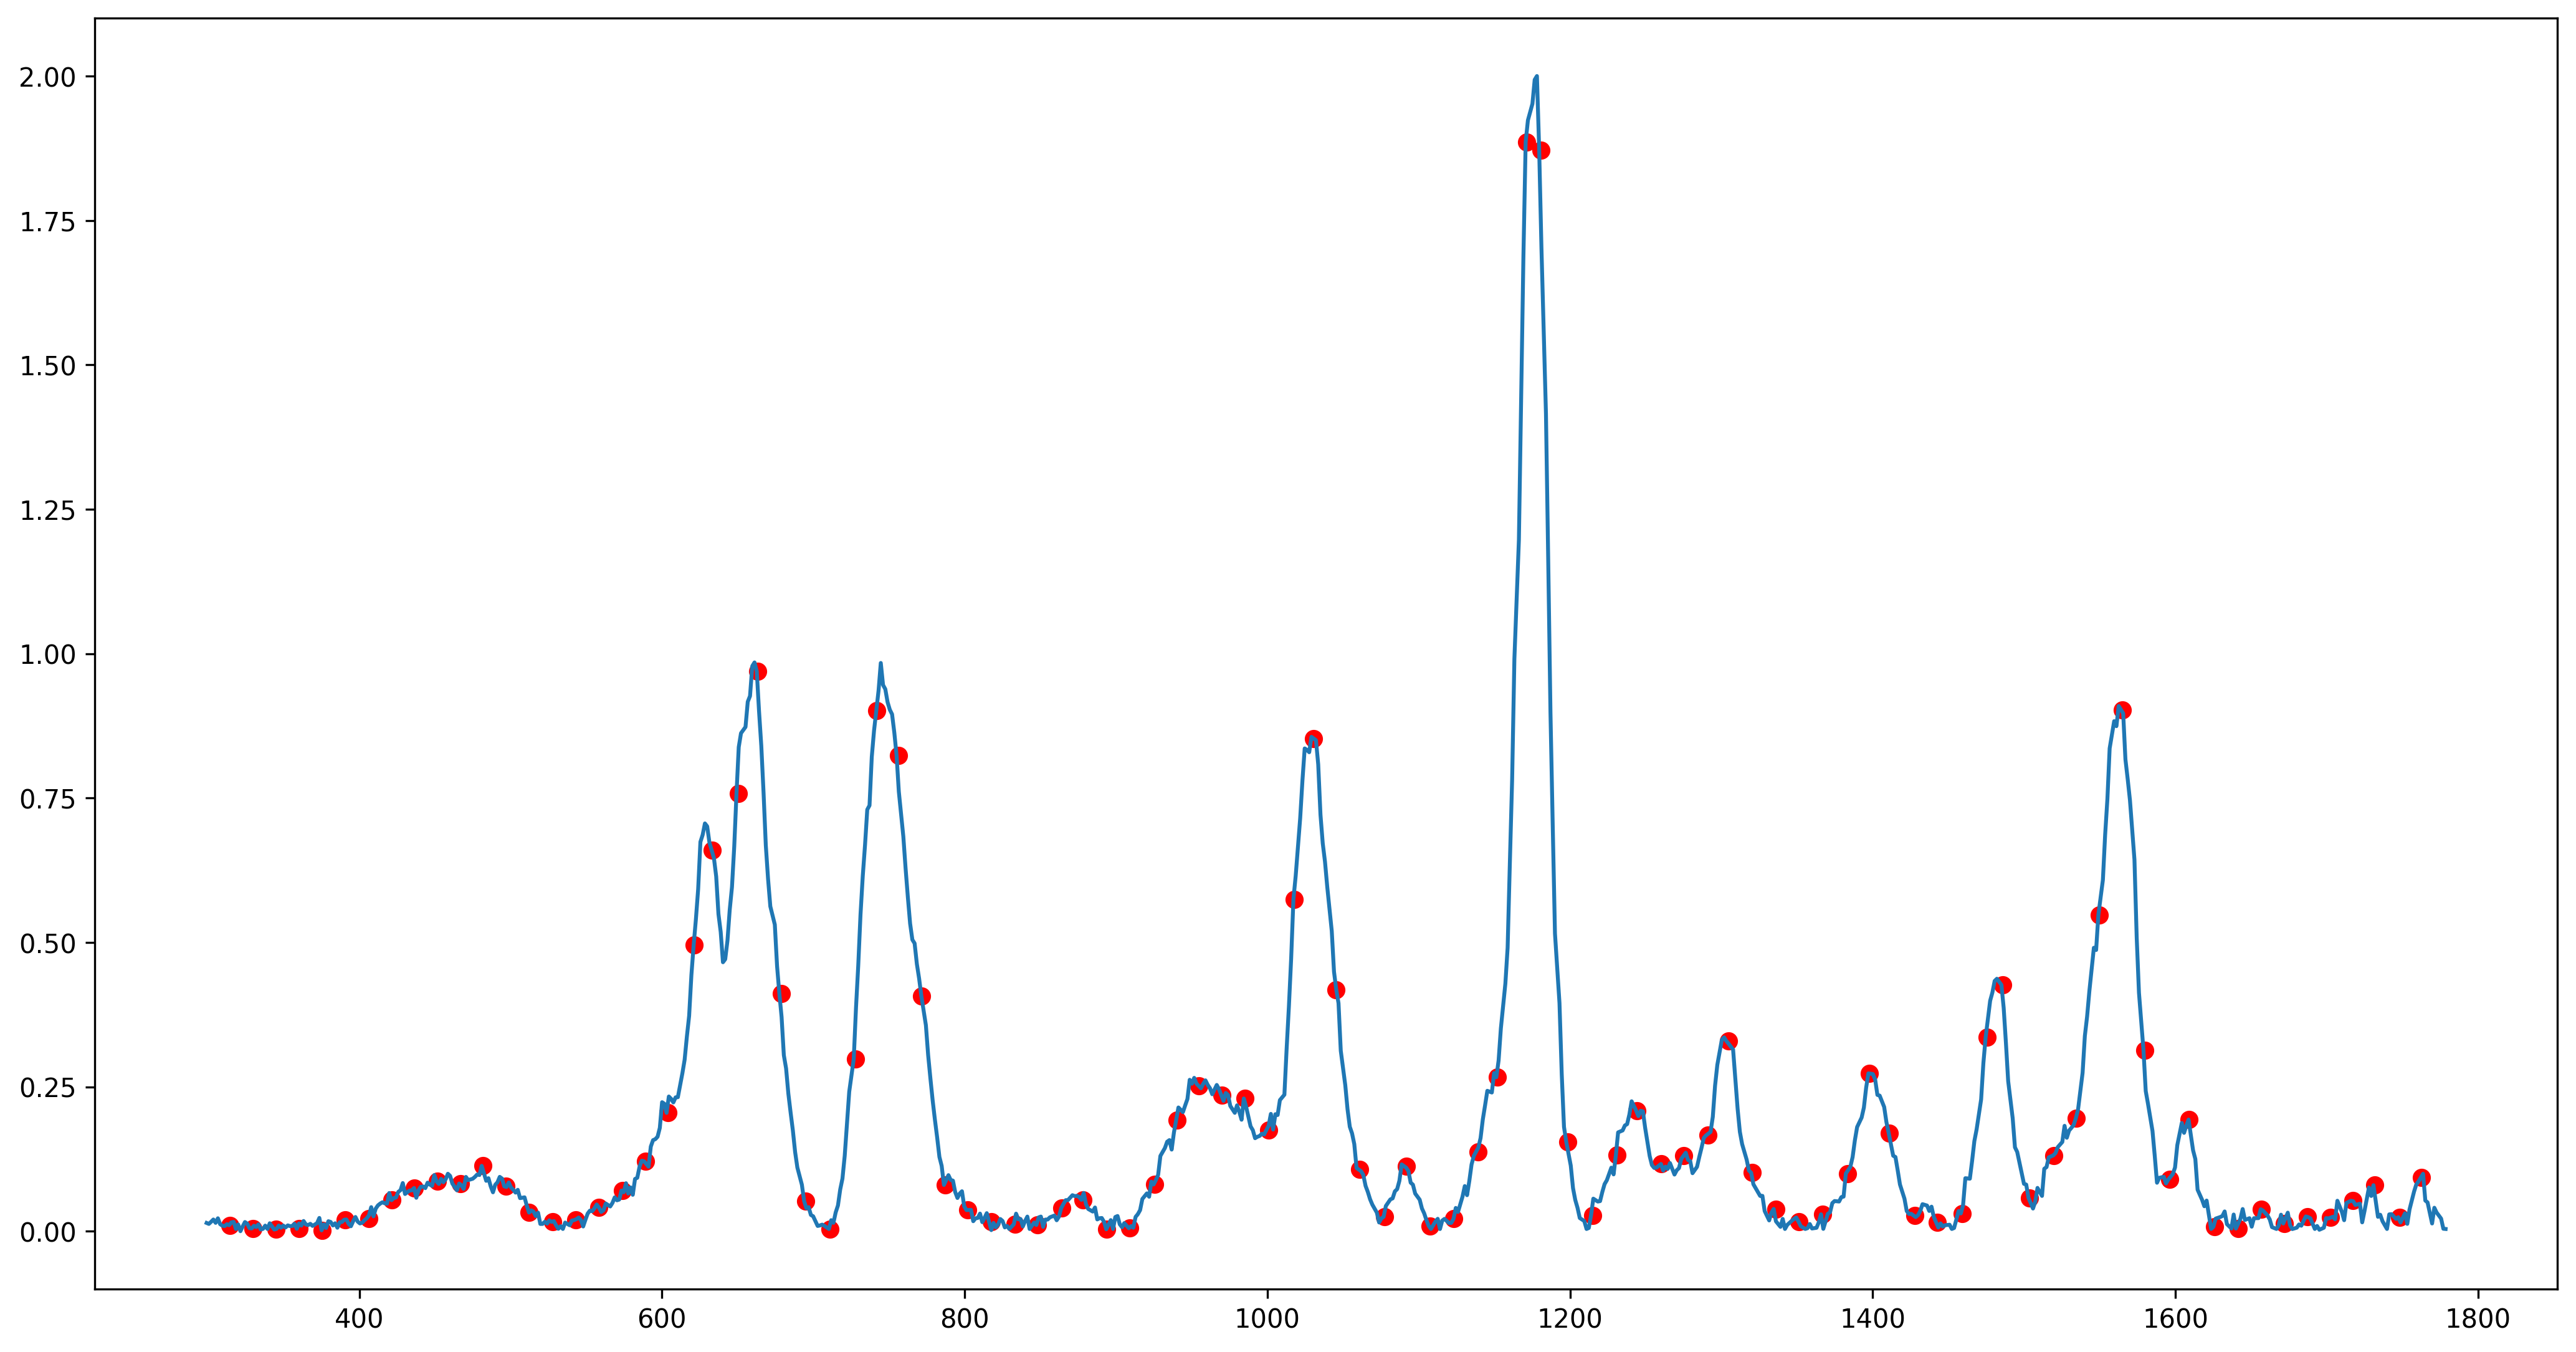

In [15]:
# index = random.choice(np.arange(filled_grid.shape[0]))
index = 107
plt.figure(figsize = (17, 9), dpi=300)
plt.plot(x_axis, spectras[index])
print(f'number of peaks: {filled_grid[index][filled_grid[index] != 0].shape[0]}, number of spectra: {index}')
plt.scatter(
    filled_grid[index][filled_grid[index] != 0], 
    (np.ones_like(filled_grid[index]) * spectras[index][:-1])[[filled_grid[index] != 0]],
    c='r'
)
plt.show()
# for i in range(filled_grid[index].shape[0]):
#     print(result_grid[i], filled_grid[index][i], result_grid[i+1])

In [472]:
X, y = filled_grid, y.reshape(-1, 1)

In [473]:
y = np.concatenate((np.zeros_like(y), y), axis=1)
y.shape

(569, 2)

In [474]:
def train_models(
    data,
    labels,
    num_estimators = 1000,
    def_tuple=(random_forest_train, xgboost_train, catboost_train), 
    description_tuple=None, 
    file_names_tuple=None,
):
    print(data.shape, labels.shape)
    metrics_array = []
    for index, func in enumerate(def_tuple):
        metrics, _ = func(
            data=data, 
            y=labels, 
            k_folds=5,
            num_estimators=num_estimators, 
            description=None if description_tuple is None else description_tuple[index], 
            class_type='class', 
            calc_metrics=True,
            file_name=None if file_names_tuple is None else file_names_tuple[index]
        )
        metrics_array.append(metrics)
    return metrics_array

In [475]:
# spectras.reshape(-1, 1, spectras.shape[1]).shape

In [476]:
# from time import time
# seed = int(time())
# np.random.seed(seed=seed)
# np.random.shuffle(spectras)
# np.random.seed(seed=seed)
# np.random.shuffle(y)

In [477]:
X.shape

(569, 993)

In [478]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=20)
cross_val_score(clf, X, spectra_labels, cv=10)

array([0.38596491, 0.43859649, 0.45614035, 0.40350877, 0.47368421,
       0.57894737, 0.52631579, 0.50877193, 0.49122807, 0.51785714])

In [479]:
import warnings
warnings.filterwarnings('ignore')

description_tuple=(
    'the first dataset with 35 gaussian peaks using RandomForest', 
    'the first dataset with 35 gaussian peaks using XGBoost', 
    'the first dataset with 35 gaussian peaks using CatBoost', 
) 
file_names_tuple=(
    "metrics/metrics_random_forest_first_dataset.txt",
    "metrics/metrics_xgboost_first_dataset.txt",
    "metrics/metrics_catboost_first_dataset.txt",
)

def_tuple=(random_forest_train, xgboost_train, catboost_train)

metrics_first_dataset = train_models(
#     spectras, 
#     np.concatenate((np.zeros_like(spectra_labels.reshape(-1, 1)), spectra_labels.reshape(-1, 1)), axis=1),
    X, 
    y, 
    def_tuple=def_tuple, 
    description_tuple=description_tuple, 
    file_names_tuple=file_names_tuple
)

(569, 993) (569, 2)
Metrics on the first dataset with 35 gaussian peaks using RandomForest:
mean accuracy           = 0.58 +- 0.048
mean f1 weighted        = 0.573 +- 0.042
mean precision weighted = 0.596 +- 0.044
mean recall weighted    = 0.58 +- 0.048
mean f1 macro           = 0.566 +- 0.036
mean precision macro    = 0.597 +- 0.037
mean recall macro       = 0.571 +- 0.046

    
Metrics on the first dataset with 35 gaussian peaks using XGBoost:
mean accuracy           = 0.719 +- 0.031
mean f1 weighted        = 0.718 +- 0.03
mean precision weighted = 0.733 +- 0.026
mean recall weighted    = 0.719 +- 0.031
mean f1 macro           = 0.705 +- 0.026
mean precision macro    = 0.724 +- 0.022
mean recall macro       = 0.705 +- 0.026

    


KeyboardInterrupt: 